<div id="top">
<!-- <div style="background-image: url(https://www.emtmadrid.es/getattachment/da3be644-cb9d-44db-8011-e3f40f1c5c34); opacity: 0.2"/> -->
<img src="https://www.gmv.com/sites/default/files/content/image/2021/11/03/115/gmv_rgbredblack.png" alt="GMV Logo" style="width: 200px">
<img src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/CEI/LOGOTIPO%20leyenda%20color%20JPG%20p.png" alt="UPM Logo" style="float: right; width: 200px">
<h1><b>EDA: EMT dataset 🚦</b></h1>
<h5 style="text-align: right">INESDATA-MOV</h5>
</div>


# Análisis EDA

En este cuaderno se realiza el análisis de datos exploratorio (EDA) del dataset de la [EMT](https://www.emtmadrid.es/Home). Una vez realizado el análisis de calidad se estudiará para el dataset resultante:

* Valores nulos y unicidad de las variables
* Correlaciones entre las variables
* Correlaciones entre las variables y la variable de estudio `estimateArrive`

Con ello se pretende hacer un filtrado de las variables que no dispongan de información relevante para el modelo o variables con la misma información. Por otro lado se hará un estudio de los valores nulos para, en caso de que sea pertinente, reconstruir estos datos. 

In [1]:
import os
import statistics
import random
import polars as pl
import pandas as pd
import seaborn as sns
import polars.selectors as cs
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import warnings

warnings.filterwarnings("ignore")

In [2]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd()))))
DATA_PATH = os.path.join(ROOT_PATH, "data", "processed")
EMT_DATA_PATH = os.path.join(DATA_PATH, "emt")


## Dataset

In [3]:
sample_data = pl.scan_csv(os.path.join(EMT_DATA_PATH, "2024", "03","13", f"emt_20240313.csv"))

In [4]:
sample_data.collect()

date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
str,str,i64,str,i64,f64,f64,i64,i64,str,i64,str,str,i64,i64,bool,str,str,i64
"""2024-03-13""","""2024-03-13 08:…",513,"""27""",56,-3.690542,40.423739,0,1841,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,false,"""LA""","""N""",473
"""2024-03-13""","""2024-03-13 08:…",521,"""27""",56,-3.689019,40.429011,0,1221,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,false,"""LA""","""N""",313
"""2024-03-13""","""2024-03-13 08:…",2549,"""150""",56,-3.691608,40.421366,0,2081,"""VIRGEN CORTIJO…",0,null,null,null,null,false,null,null,547
"""2024-03-13""","""2024-03-13 08:…",2561,"""150""",56,-3.698411,40.418013,0,2779,"""VIRGEN CORTIJO…",0,null,null,null,null,false,null,null,1080
"""2024-03-13""","""2024-03-13 08:…",5571,"""14""",56,-3.687918,40.43285,0,679,"""PIO XII""",0,null,null,null,null,false,null,null,197
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""2024-03-13""","""2024-03-13 22:…",2141,"""174""",51023,-3.667048,40.489136,0,8114,"""VALDEBEBAS""",0,"""06:00""","""23:45""",7,22,false,"""LA""","""N""",1225
"""2024-03-13""","""2024-03-13 22:…",8810,"""171""",51023,0.0,0.0,0,13290,"""VALDEBEBAS""",0,null,null,null,null,false,null,null,2163
"""2024-03-13""","""2024-03-13 22:…",8829,"""171""",51023,0.0,0.0,0,2088,"""VALDEBEBAS""",0,null,null,null,null,false,null,null,396


### Variables numéricas

In [5]:
sample_data.select(cs.numeric()).head().collect()

bus,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,deviation,MinimunFrequency,MaximumFrequency,estimateArrive
i64,i64,f64,f64,i64,i64,i64,i64,i64,i64
513,56,-3.690542,40.423739,0,1841,0,3,12,473
521,56,-3.689019,40.429011,0,1221,0,3,12,313
2549,56,-3.691608,40.421366,0,2081,0,null,null,547
2561,56,-3.698411,40.418013,0,2779,0,null,null,1080
5571,56,-3.687918,40.43285,0,679,0,null,null,197


### Variables categóricas

In [6]:
sample_data.select(cs.string()).head().collect()

date,datetime,line,destination,StartTime,StopTime,dayType,strike
str,str,str,str,str,str,str,str
"""2024-03-13""","""2024-03-13 08:…","""27""","""PLAZA CASTILLA…","""05:55""","""23:30""","""LA""","""N"""
"""2024-03-13""","""2024-03-13 08:…","""27""","""PLAZA CASTILLA…","""05:55""","""23:30""","""LA""","""N"""
"""2024-03-13""","""2024-03-13 08:…","""150""","""VIRGEN CORTIJO…",null,null,null,null
"""2024-03-13""","""2024-03-13 08:…","""150""","""VIRGEN CORTIJO…",null,null,null,null
"""2024-03-13""","""2024-03-13 08:…","""14""","""PIO XII""",null,null,null,null


## Preprocesamiento previo 
### Creamos la PK

In [7]:
sample_data = sample_data.with_columns((pl.col('datetime').cast(pl.String)+"_B"+pl.col('bus').cast(pl.String)+"_L"+ pl.col('line').cast(pl.String)+"_S"+pl.col('stop').cast(pl.String)).alias('PK'))
sample_data.head().collect()

date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive,PK
str,str,i64,str,i64,f64,f64,i64,i64,str,i64,str,str,i64,i64,bool,str,str,i64,str
"""2024-03-13""","""2024-03-13 08:…",513,"""27""",56,-3.690542,40.423739,0,1841,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,false,"""LA""","""N""",473,"""2024-03-13 08:…"
"""2024-03-13""","""2024-03-13 08:…",521,"""27""",56,-3.689019,40.429011,0,1221,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,false,"""LA""","""N""",313,"""2024-03-13 08:…"
"""2024-03-13""","""2024-03-13 08:…",2549,"""150""",56,-3.691608,40.421366,0,2081,"""VIRGEN CORTIJO…",0,null,null,null,null,false,null,null,547,"""2024-03-13 08:…"
"""2024-03-13""","""2024-03-13 08:…",2561,"""150""",56,-3.698411,40.418013,0,2779,"""VIRGEN CORTIJO…",0,null,null,null,null,false,null,null,1080,"""2024-03-13 08:…"
"""2024-03-13""","""2024-03-13 08:…",5571,"""14""",56,-3.687918,40.43285,0,679,"""PIO XII""",0,null,null,null,null,false,null,null,197,"""2024-03-13 08:…"


**PK no única**

In [8]:
sample_data.group_by(pl.col('PK')).count().sort('count',descending = True).head().collect()

PK,count
str,u32
"""2024-03-13 22:…",2
"""2024-03-13 22:…",2
"""2024-03-13 22:…",2
"""2024-03-13 22:…",2
"""2024-03-13 22:…",2


### Eliminamos los valores incorrectos `estimateArrive`

In [9]:
sample_data.group_by(pl.col('estimateArrive')).count().sort('estimateArrive',descending=True).head().collect()

estimateArrive,count
i64,u32
999999,2558
888888,753
5389,1
5343,1
5339,1


Filtramos por un ETA < 88888 ya que es un valor de tiempo erróneo

In [10]:
sample_data = sample_data.filter(pl.col('estimateArrive')<888888)

**Comprobamos que la PK es única**

In [11]:
sample_data.group_by(pl.col('PK')).count().sort('count',descending = True).head().collect()

PK,count
str,u32
"""2024-03-13 22:…",2
"""2024-03-13 10:…",2
"""2024-03-13 10:…",2
"""2024-03-13 10:…",2
"""2024-03-13 10:…",2


Sigue habiendo datos duplicados, por lo que para esos casos, cogeremos el que tenga menor ETA

In [12]:
sample_data = sample_data.group_by('PK').min()

In [13]:
sample_data.group_by('PK').count().sort('count',descending=True).head().collect()

PK,count
str,u32
"""2024-03-13 15:…",1
"""2024-03-13 17:…",1
"""2024-03-13 17:…",1
"""2024-03-13 12:…",1
"""2024-03-13 14:…",1


## Matriz de confusión

**Pasamos `datetime` a formato fecha**

In [14]:
sample_data = sample_data.with_columns(pl.col('datetime').map_elements(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f")))

**Pasamos `date` a formato fecha**

In [15]:
sample_data = sample_data.with_columns(pl.col("date").cast(pl.Date))

**Pasamos la variable `isHead` a numérica**

In [16]:
sample_data = sample_data.with_columns(pl.col('isHead').cast(pl.UInt8))

In [17]:
sample_data.head().collect()

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
str,date,datetime[μs],i64,str,i64,f64,f64,i64,i64,str,i64,str,str,i64,i64,u8,str,str,i64
"""2024-03-13 13:…",2024-03-13,2024-03-13 13:57:02.921708,5575,"""14""",54,-3.692133,40.420172,0,2227,"""PIO XII""",0,null,null,null,null,0,null,null,844
"""2024-03-13 21:…",2024-03-13,2024-03-13 21:53:03.331814,5667,"""40""",52,-3.697028,40.432398,0,4060,"""ALFONSO XIII""",0,null,null,null,null,0,null,null,1406
"""2024-03-13 13:…",2024-03-13,2024-03-13 13:41:03.386037,4793,"""45""",72,-3.694743,40.392751,0,2869,"""REINA VICTORIA…",0,null,null,null,null,0,null,null,1085
"""2024-03-13 13:…",2024-03-13,2024-03-13 13:56:54.781069,521,"""27""",54,-3.689548,40.43714,0,612,"""PLAZA CASTILLA…",0,"""05:55""","""23:30""",3,12,0,"""LA""","""N""",194
"""2024-03-13 18:…",2024-03-13,2024-03-13 18:24:05.996058,2468,"""134""",4968,-3.713937,40.483179,0,1207,"""MONTECARMELO""",0,"""06:25""","""23:45""",9,26,0,"""LA""","""N""",283


In [18]:
numeric_var = ['bus', 'line','stop',
 'positionBusLon',
 'positionBusLat',
 'DistanceBus',
 'deviation',
 'MinimunFrequency',
 'MaximumFrequency',
 'isHead',
 'estimateArrive',]

In [19]:
sample_data_df = sample_data.collect()

In [20]:
matrix = [[0] * len(numeric_var) for _ in range(len(numeric_var))]
for i in range(0,len(numeric_var)):
    for j in range(0,len(numeric_var)):
        matrix[i][j] = sample_data_df.select(pl.corr(numeric_var[i],numeric_var[j])).item()

In [21]:
matrix_corr = pd.DataFrame(matrix, columns=numeric_var,index=numeric_var).apply(lambda col: col.round(2))

In [22]:
matrix_corr

,bus,line,stop,positionBusLon,positionBusLat,DistanceBus,deviation,MinimunFrequency,MaximumFrequency,isHead,estimateArrive
bus,1.00,0.04,0.11,0.27,-0.27,0.00,0.09,0.10,0.28,0.01,0.07
line,0.04,1.00,0.24,-0.08,0.09,0.27,0.01,0.43,0.39,0.08,0.12
stop,0.11,0.24,1.00,0.08,-0.07,0.13,-0.02,0.01,0.07,0.26,0.06
positionBusLon,0.27,-0.08,0.08,1.00,-1.00,0.12,-0.01,0.02,-0.02,-0.02,0.11
positionBusLat,-0.27,0.09,-0.07,-1.00,1.00,-0.11,0.01,0.02,0.02,0.02,-0.10
DistanceBus,0.00,0.27,0.13,0.12,-0.11,1.00,0.00,0.24,0.22,-0.06,0.86
deviation,0.09,0.01,-0.02,-0.01,0.01,0.00,1.00,-0.00,-0.00,-0.02,0.02
MinimunFrequency,0.10,0.43,0.01,0.02,0.02,0.24,-0.00,1.00,0.78,0.03,0.30
MaximumFrequency,0.28,0.39,0.07,-0.02,0.02,0.22,-0.00,0.78,1.00,0.04,0.26
isHead,0.01,0.08,0.26,-0.02,0.02,-0.06,-0.02,0.03,0.04,1.00,0.02


<Axes: >

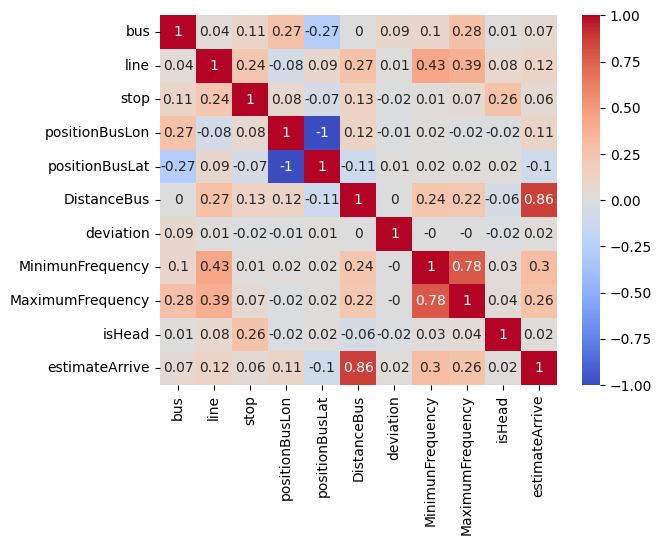

In [23]:
sns.heatmap(matrix_corr, cmap='coolwarm',vmin=-1, vmax=1,annot= True)

In [24]:
matrix_corr.to_csv('/home/mlia/proyectos/data-generation/docs/notebooks/aux/matrix_corr_emt.csv', index=False)

Obtenemos que las variables más correladas entre sí son:
- `positionBusLon` y `positionBusLat`
- `MinimunFrequency` y `MaximumFrequency`

Además la variable más correlada con `estimateArrive` es `DistanceBus`

## Estudio por variables

Para cada variable:
1. Comprobaremos si tiene valores nulos 
2. Calcularemos la correlación con la variable `estimateArrive`
3. Dibujaremos el tiempo medio de llegada según sus categorías en el caso en el que fuera posible
4. Decidiremos si la mantenemos o la eliminamos

In [25]:
sample_data.head().describe() 

statistic,PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,deviation,StartTime,StopTime,MinimunFrequency,MaximumFrequency,isHead,dayType,strike,estimateArrive
str,str,str,str,f64,str,f64,f64,f64,f64,f64,str,f64,str,str,f64,f64,f64,str,str,f64
"""count""","""5""","""5""","""5""",5.0,"""5""",5.0,5.0,5.0,5.0,5.0,"""5""",5.0,"""4""","""4""",4.0,4.0,5.0,"""4""","""4""",5.0
"""null_count""","""0""","""0""","""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,"""0""",0.0,"""1""","""1""",1.0,1.0,0.0,"""1""","""1""",0.0
"""mean""",null,"""2024-03-13""",null,2826.6,null,2255.0,-3.679584,40.464248,0.0,3542.0,null,0.0,null,null,5.75,20.25,0.0,null,null,742.2
"""std""",null,null,null,3510.668711,null,2304.700631,0.015201,0.034255,0.0,2000.683633,null,0.0,null,null,1.258306,2.362908,0.0,null,null,544.644104
"""min""","""2024-03-13 11:…","""2024-03-13""",null,122.0,"""174""",78.0,-3.702037,40.405106,0.0,339.0,"""ALSACIA""",0.0,"""05:30""","""23:45""",4.0,17.0,0.0,"""LA""","""N""",76.0
"""25%""",null,"""2024-03-13""",null,584.0,null,246.0,-3.685782,40.464995,0.0,3195.0,null,0.0,null,null,6.0,20.0,0.0,null,null,281.0
"""50%""",null,"""2024-03-13""",null,2071.0,null,1762.0,-3.678519,40.478297,0.0,3891.0,null,0.0,null,null,6.0,22.0,0.0,null,null,860.0
"""75%""",null,"""2024-03-13""",null,2506.0,null,3794.0,-3.666058,40.483716,0.0,4703.0,null,0.0,null,null,6.0,22.0,0.0,null,null,1190.0
"""max""","""2024-03-13 22:…","""2024-03-13""",null,8850.0,"""C03""",5395.0,-3.665525,40.489127,0.0,5582.0,"""VALDEBEBAS""",0.0,"""06:00""","""23:45""",7.0,22.0,0.0,"""LA""","""N""",1304.0


**Variable `date`**

Valores nulos

In [26]:
sample_data.group_by(pl.col('date')).count().head().collect()

date,count
date,u32
2024-03-13,1131139


**Variable `datetime`**

Valores nulos

In [27]:
sample_data.group_by(pl.col('datetime')).count().head().collect()

datetime,count
datetime[μs],u32
2024-03-13 11:37:57.321267,2
2024-03-13 13:26:54.208612,12
2024-03-13 09:59:29.140672,4
2024-03-13 10:52:58.664917,4
2024-03-13 21:01:54.748638,2


**Variable `bus`**

Valores nulos

In [28]:
sample_data.group_by(pl.col('bus')).count().head().collect()

bus,count
i64,u32
3317,1260
4329,59
2266,515
4758,17
548,229


Correlación

In [29]:
sample_data.select(pl.corr('bus','estimateArrive')).head().collect()

bus
f64
0.06748


Tiempo medio de espera según autobús

In [30]:
sample_data.group_by(pl.col('bus')).mean().select(pl.col('bus'),pl.col('estimateArrive')).head().collect()

bus,estimateArrive
i64,f64
4755,398.504202
2504,1082.137097
5654,380.661765
560,442.948276
563,528.829897


Según que autobús sea, el tiempo medio de espera varia bastante. Por lo que esta variable va a ser necesaria a la hora de la creación de nuestro modelo.

**Variable `line`**

Valores nulos

In [31]:
sample_data.group_by(pl.col('line')).count().head().collect()

line,count
str,u32
"""167""",3352
"""67""",46138
"""48""",13481
"""173""",23933
"""C2""",1650


Correlación

In [32]:
sample_data.select(pl.corr('line','estimateArrive')).head().collect()

line
f64
0.120876


Tiempo medio de espera según línea

In [33]:
sample_data.group_by(pl.col('line')).mean().select(pl.col('line'),pl.col('estimateArrive')).collect().plot.bar(x='line',rot=90)

:Bars   [line]   (estimateArrive)

Según que línea sea, el tiempo medio de espera varia bastante. Por lo que esta variable va a ser necesaria a la hora de la creación de nuestro modelo.

**Variable `stop`**

Valores nulos

In [34]:
sample_data.group_by(pl.col('stop')).count().head().collect()

stop,count
i64,u32
1745,3446
5919,3435
5803,1707
30,6801
271,1721


Correlación

In [35]:
sample_data.select(pl.corr('stop','estimateArrive')).head().collect()

stop
f64
0.063389


Tiempo medio de espera según parada

In [36]:
sample_data.group_by(pl.col('stop')).mean().select(pl.col('stop'),pl.col('estimateArrive')).head().collect()

stop,estimateArrive
i64,f64
5800,804.162099
4493,711.560164
1608,605.882045
5919,773.480058
5803,786.485647


Según que parada sea, el tiempo medio de espera varia bastante. Por lo que esta variable va a ser necesaria a la hora de la creación de nuestro modelo.

**Variable `positionBusLon`**

Valores nulos

In [37]:
sample_data.group_by(pl.col('positionBusLon')).count().head().collect()

positionBusLon,count
f64,u32
-3.697979,3
-3.647153,1
-3.6347,7
-3.711168,2
-3.713401,23


Correlación

In [38]:
sample_data.select(pl.corr('positionBusLon','estimateArrive')).head().collect()

positionBusLon
f64
0.10522


**Variable `positionBusLat`**

Valores nulos

In [39]:
sample_data.group_by(pl.col('positionBusLat')).count().head().collect()

positionBusLat,count
f64,u32
40.481868,9
40.467639,17
40.424176,2
40.469551,24
40.475646,9


Correlación

In [40]:
sample_data.select(pl.corr('positionBusLat','estimateArrive')).head().collect()

positionBusLat
f64
-0.103452


**Variable `positionTypeBus`**

Valores nulos

In [41]:
sample_data.group_by(pl.col('positionTypeBus')).count().head().collect()

positionTypeBus,count
i64,u32
1,11
5,1356
0,1129772


Correlación

In [42]:
sample_data.select(pl.corr('positionTypeBus','estimateArrive')).head().collect()

positionTypeBus
f64
0.028544


Como no tenemos información acerca del significado de esta variable, no podemos entenderla por lo que decidimos eliminarla

In [43]:
sample_data = sample_data.drop('positionBusType')

**Variable `DistanceBus`**

Valores nulos

In [44]:
sample_data.group_by(pl.col('DistanceBus')).count().head().collect()

DistanceBus,count
i64,u32
10888,3
5651,48
6443,37
2385,248
670,284


Correlación

In [45]:
sample_data.select(pl.corr('DistanceBus','estimateArrive')).head().collect()

DistanceBus
f64
0.857959


Como era de esperar, es la variable que mayor correlación tiene con el `ETA`

**Variable `destination`**

Valores nulos

In [46]:
sample_data.group_by(pl.col('destination')).count().head().collect()

destination,count
str,u32
"""TELEFONICA""",5120
"""SANCHINARRO""",37472
"""BARRIO DEL PIL…",54330
"""PLAZA CATALUÑA…",1672
"""REINA VICTORIA…",18282


Tiempo medio de espera según destino

In [47]:
sample_data.group_by(pl.col('destination')).mean().select(pl.col('destination'),pl.col('estimateArrive')).collect().plot.bar(x='destination',rot=90)

:Bars   [destination]   (estimateArrive)

Según que destino sea, el tiempo medio de espera varia bastante. Por lo que esta variable va a ser necesaria a la hora de la creación de nuestro modelo.

**Variable `deviation`**

Valores nulos

In [48]:
sample_data.group_by(pl.col('deviation')).count().head().collect()

deviation,count
i64,u32
137,6
0,1123941
5261,3092
537,38
8585,4044


Correlación

In [49]:
sample_data.select(pl.corr('deviation','estimateArrive')).head().collect()

deviation
f64
0.022565


In [50]:
sample_data.group_by(pl.col('deviation')).mean().select(pl.col('deviation'),pl.col('estimateArrive')).sort('deviation', descending=True).collect()

deviation,estimateArrive
i64,f64
8585,799.088279
5261,711.674968
1259,367.625
537,463.5
288,517.5
137,512.833333
0,637.801457


No tenemos información acerca del significado de esta variable. Por lo que la eliminamos también

In [51]:
sample_data = sample_data.drop('deviation')

**Variable `StartTime`**

Valores nulos

In [52]:
sample_data.group_by(pl.col('StartTime')).count().sort(pl.col('StartTime'),descending=True).collect()

StartTime,count
str,u32
null,533127
"""06:30""",13514
"""06:25""",54669
"""06:20""",23954
"""06:15""",41060
"""06:10""",61758
"""06:00""",306036
"""05:55""",47464
"""05:30""",49557


**Variable `StopTime`**

Valores nulos

In [53]:
sample_data.group_by(pl.col('StopTime')).count().sort(pl.col('StopTime'),descending=True).collect()

StopTime,count
str,u32
null,533127
"""23:45""",526594
"""23:30""",71418


La información que nos dan las dos variables anteriores refleja que estamos considerando solo autobuses diurnos e ignorando los nocturnos. Por tanto, esta variable no va a inferir en el tiempo de estimación ya que el hecho de que su horario comience a las 6 de la mañana o a las 7 de la mañana no va a depender de que tarde más o menos a lo largo del día. Por tanto consideramos que se pueden borrar también.

In [54]:
sample_data = sample_data.drop('StartTime','StopTime')

**Variable `MinimunFrequency`**

Valores nulos

In [55]:
sample_data.group_by(pl.col('MinimunFrequency')).count().head().collect()

MinimunFrequency,count
i64,u32
null,533127
7,116427
3,47464
6,71872
12,40808


Correlación

In [56]:
sample_data.select(pl.corr('MinimunFrequency','estimateArrive')).head().collect()

MinimunFrequency
f64
0.302355


**Variable `MaximumFrequency`**

Valores nulos

In [57]:
sample_data.group_by(pl.col('MaximumFrequency')).count().sort(pl.col('MaximumFrequency'),descending=True).collect()

MaximumFrequency,count
i64,u32
null,533127
30,46138
29,13514
26,54669
24,102448
…,…
21,23933
20,37704
17,49557


Correlación

In [58]:
sample_data.select(pl.corr('MaximumFrequency','estimateArrive')).head().collect()

MaximumFrequency
f64
0.260828


Las variables `MinimunFrequency ` y `MaximumFrequency ` tienen muchos valores nulos pero si que están relacionadas con el `ETA`. Una opción es mantener solo una de ellas ya que es probable que aporten la misma información. De momento mantenemos las dos.

**Variable `isHead`**

Valores nulos

In [59]:
sample_data.group_by(pl.col('isHead')).count().head().collect()

isHead,count
u8,u32
0,1068067
1,63072


Correlación

In [60]:
sample_data.select(pl.corr('isHead','estimateArrive')).head().collect()

isHead
f64
0.018379


Tiempo medio de espera según si el autobús es cabecera o no

In [61]:
sample_data.group_by(pl.col('isHead')).mean().select(pl.col('isHead'),pl.col('estimateArrive')).head().collect().plot.bar(x='isHead')

:Bars   [isHead]   (estimateArrive)

In [62]:
sample_data.group_by(pl.col('isHead')).mean().select(pl.col('isHead'),pl.col('estimateArrive')).head().collect()

isHead,estimateArrive
u8,f64
1,673.029807
0,636.534496


Mantenemos esta variable ya que está bastante relacionada con el `ETA`

**Variable `dayType`**

Valores nulos

In [63]:
sample_data.group_by(pl.col('dayType')).count().head().collect()

dayType,count
str,u32
"""LA""",598012
null,533127


**Vemos de que tipo son los días nulos utilizando la fecha**

In [64]:
def get_type_day(date):
    
    day = date.strftime("%A")
    
    if day in ['Monday','Tuesday','Wednesday','Thursday','Friday']:
        
        type = 'LA'
    elif day == 'Saturday':
        type = 'SA'
    else:
        type = 'FE'
        
    return type

In [65]:
sample_data = sample_data.with_columns(pl.when(pl.col('dayType').is_null()).then(pl.col('date').apply(get_type_day)).otherwise(pl.col('dayType')).alias('dayType'))

In [66]:
sample_data.group_by(pl.col('dayType')).count().head().collect()

dayType,count
str,u32
"""LA""",1131139


**Variable `strike`**

Valores nulos

In [67]:
sample_data.group_by(pl.col('strike')).count().head().collect()

strike,count
str,u32
null,533127
"""N""",598012


In [68]:
sample_data.group_by(pl.col('strike')).mean().select(pl.col('strike'),pl.col('estimateArrive')).head().collect()

strike,estimateArrive
str,f64
null,687.680016
"""N""",594.787466


- La variable `Strike` toma solo 'N' o nulo, por lo que para ningún día se tiene constancia de que hubo huelga. Por tanto para estos datos esta variable no va a aportar información.

In [69]:
sample_data = sample_data.drop('strike')
sample_data.head().collect()

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,MinimunFrequency,MaximumFrequency,isHead,dayType,estimateArrive
str,date,datetime[μs],i64,str,i64,f64,f64,i64,i64,str,i64,i64,u8,str,i64
"""2024-03-13 12:…",2024-03-13,2024-03-13 12:14:06.145791,5552,"""42""",5018,-3.689362,40.467008,0,880,"""BARRIO PEÑAGRA…",7,24,0,"""LA""",232
"""2024-03-13 12:…",2024-03-13,2024-03-13 12:58:02.776095,4757,"""19""",89,-3.694772,40.392075,0,1550,"""PLAZA CATALUÑA…",null,null,0,"""LA""",434
"""2024-03-13 10:…",2024-03-13,2024-03-13 10:00:02.709359,4737,"""49""",1542,-3.689145,40.467685,0,2618,"""PITIS""",4,15,0,"""LA""",707
"""2024-03-13 15:…",2024-03-13,2024-03-13 15:07:05.141116,2132,"""107""",1841,-3.6667,40.469799,0,1855,"""HORTALEZA""",11,22,0,"""LA""",363
"""2024-03-13 15:…",2024-03-13,2024-03-13 15:08:07.085498,4725,"""49""",5636,-3.700473,40.468273,0,137,"""PITIS""",4,15,0,"""LA""",39


**Variable `estimateArrive`**

Valores nulos

In [70]:
sample_data.group_by(pl.col('estimateArrive')).count().head().collect()

estimateArrive,count
i64,u32
1727,78
828,750
2236,13
167,959
423,947


**Resumen**


In [71]:
sample_data.select(pl.col('estimateArrive')).describe()

statistic,estimateArrive
str,f64
"""count""",1.131139e6
"""null_count""",0.0
"""mean""",638.569465
"""std""",455.633197
"""min""",0.0
"""25%""",274.0
"""50%""",566.0
"""75%""",922.0
"""max""",5389.0



- Las variables `MinimunFrequency ` y `MaximumFrequency ` están muy relacionadas entre ellas. Se podría dejar tan solo `MinimumFrequency` ya que aporta mas informacion al `ETA` que la otra


 

In [72]:
sample_data = sample_data.drop('MaximumFrequency')
sample_data.head().collect()

PK,date,datetime,bus,line,stop,positionBusLon,positionBusLat,positionTypeBus,DistanceBus,destination,MinimunFrequency,isHead,dayType,estimateArrive
str,date,datetime[μs],i64,str,i64,f64,f64,i64,i64,str,i64,u8,str,i64
"""2024-03-13 09:…",2024-03-13,2024-03-13 09:51:55.581672,4860,"""49""",1550,-3.71357,40.483189,0,642,"""PITIS""",4,0,"""LA""",230
"""2024-03-13 16:…",2024-03-13,2024-03-13 16:53:04.751456,2468,"""134""",2864,-3.708434,40.498855,0,575,"""MONTECARMELO""",9,0,"""LA""",209
"""2024-03-13 16:…",2024-03-13,2024-03-13 16:14:04.487383,2310,"""178""",1760,-3.685786,40.47828,0,3282,"""MONTECARMELO""",6,0,"""LA""",415
"""2024-03-13 16:…",2024-03-13,2024-03-13 16:56:06.220714,9120,"""177""",5800,-3.688153,40.467592,0,910,"""MARQUES DE VIA…",9,0,"""LA""",607
"""2024-03-13 08:…",2024-03-13,2024-03-13 08:29:03.023408,5637,"""147""",29,-3.690032,40.455447,0,972,"""BARRIO DEL PIL…",null,0,"""LA""",170


## Conclusión

Para cada _.csv_ de un día concreto vamos a crear otro _.csv_ que tan solo tenga las columnas:
- `PK`
- `predict_arrival_date`
- `reliable_arrival_date`

Por otro lado vamos a crear otro _.csv_ que tenga las columnas:
- `PK`
- `date`
- `datetime`
- `bus`
- `line`
- `stop`
- `positionBusLon`
- `positionBusLat` 
- `DistanceBus`
- `destination`
- `MinimunFrequency`
- `isHead`
- `dayType`
- `estimateArrive`

El dataset de entrenamiento será la concatenación de todos los días y el join de ambos mediante la `PK`
